In [9]:
import pandas as pd

df = pd.read_csv("Working_df/Actuals_2020-2023.csv")

df['week_start'] = pd.to_datetime(df['week_start'])

# Aggregate weekly total sales
weekly_sales = df.groupby('week_start')['Sum of Invoiced Amount EUR'].sum().asfreq('W-MON')

# Fill any missing weeks with 0
weekly_sales = weekly_sales.fillna(0)

# Preview
print(weekly_sales.head())


C:\Users\danii\AppData\Local\Temp\ipykernel_18004\1160792749.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Working_df/Actuals_2020-2023.csv")


week_start
2021-12-27    1.664279e+05
2022-01-03    4.040237e+06
2022-01-10    8.908187e+06
2022-01-17    9.497029e+06
2022-01-24    1.082948e+07
Freq: W-MON, Name: Sum of Invoiced Amount EUR, dtype: float64


In [10]:
print(weekly_sales.shape)

(158,)


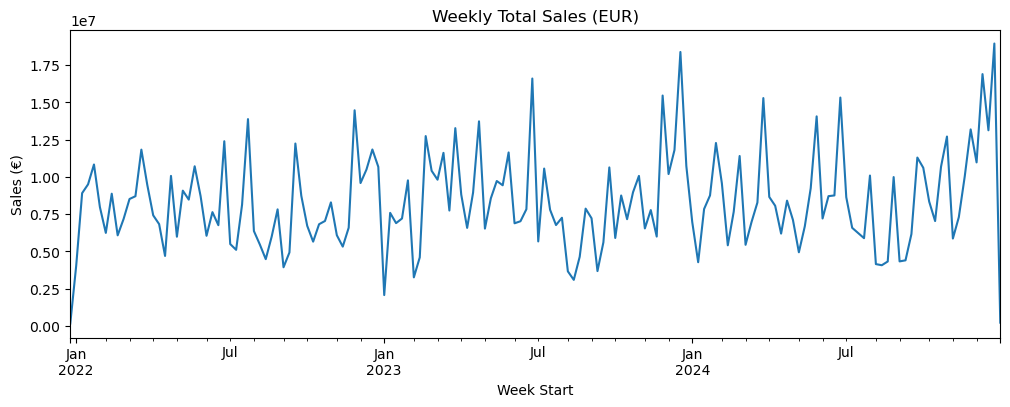

ADF Statistic: -3.3848
p-value: 0.0115


In [11]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Plot the weekly sales
weekly_sales.plot(figsize=(12, 4), title="Weekly Total Sales (EUR)")
plt.ylabel("Sales (€)")
plt.xlabel("Week Start")
plt.show()

# ADF Test
adf_result = adfuller(weekly_sales)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")


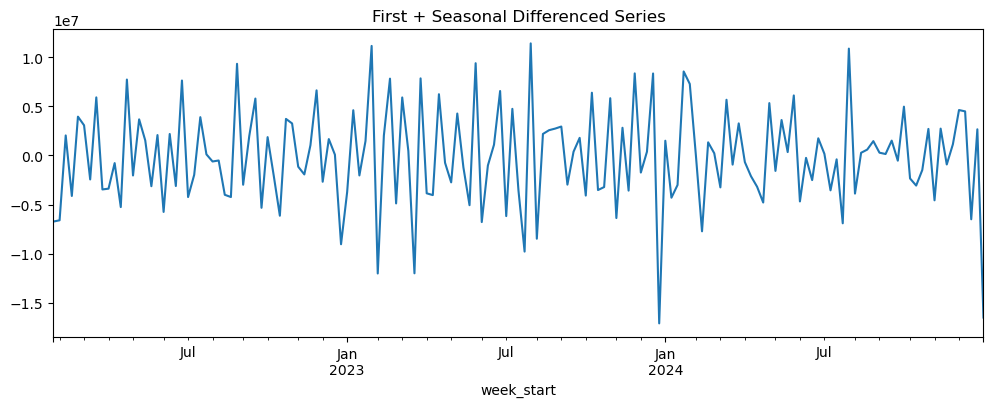

In [12]:
import matplotlib.pyplot as plt

# Apply first differencing
diff_1 = weekly_sales.diff().dropna()

# Seasonal differencing (4-week seasonality)
diff_1_seasonal = diff_1.diff(4).dropna()

# Plot the result
plt.figure(figsize=(12, 4))
diff_1_seasonal.plot(title="First + Seasonal Differenced Series")
plt.show()


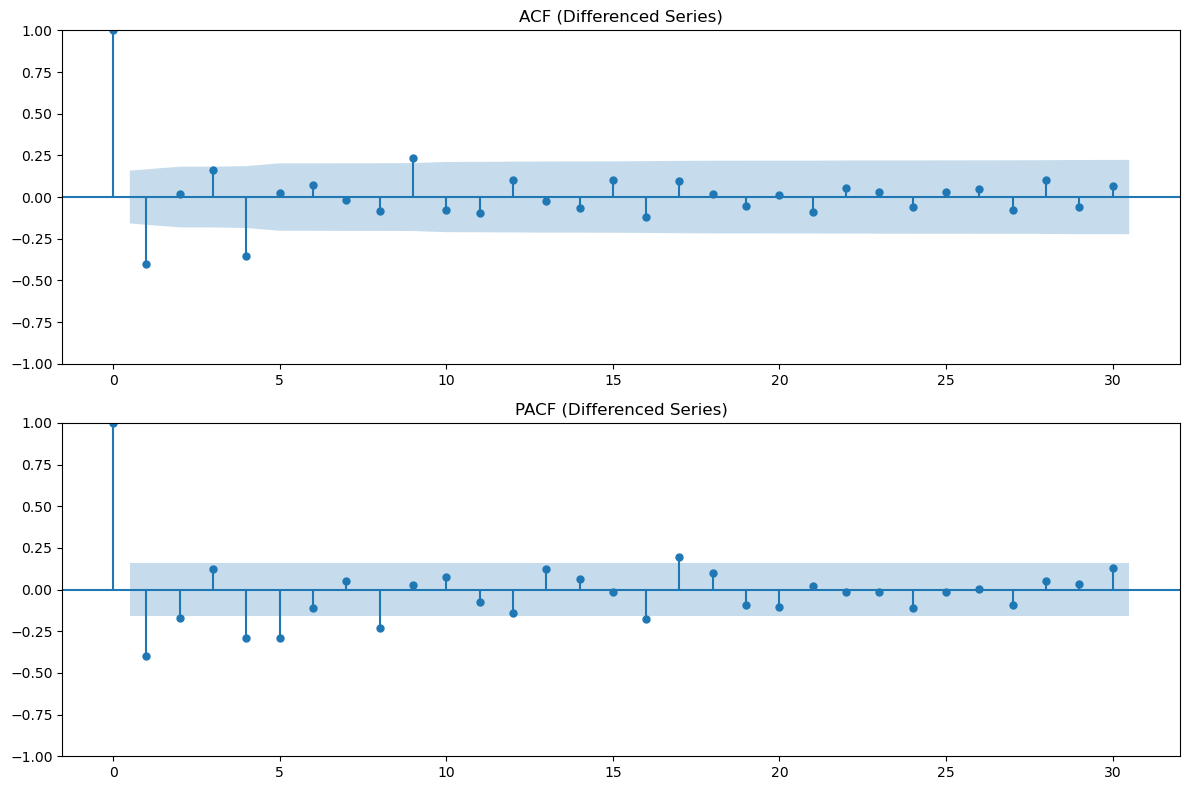

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(diff_1_seasonal, lags=30, ax=axes[0])
axes[0].set_title('ACF (Differenced Series)')

plot_pacf(diff_1_seasonal, lags=30, ax=axes[1])
axes[1].set_title('PACF (Differenced Series)')

plt.tight_layout()
plt.show()


In [14]:
print(f"Total data points in weekly_sales: {len(weekly_sales)}")
print(f"Total data points after full differencing: {len(diff_1_seasonal)}")


Total data points in weekly_sales: 158
Total data points after full differencing: 153


In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    weekly_sales,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 0, 4),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:         Sum of Invoiced Amount EUR   No. Observations:                  158
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 4)   Log Likelihood               -2449.323
Date:                            Wed, 16 Apr 2025   AIC                           4906.646
Time:                                    13:58:12   BIC                           4918.635
Sample:                                12-27-2021   HQIC                          4911.517
                                     - 12-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1349      0.129      1.042      0.297      -0.119       0.389
ma.L1         -1.0027      0.009   

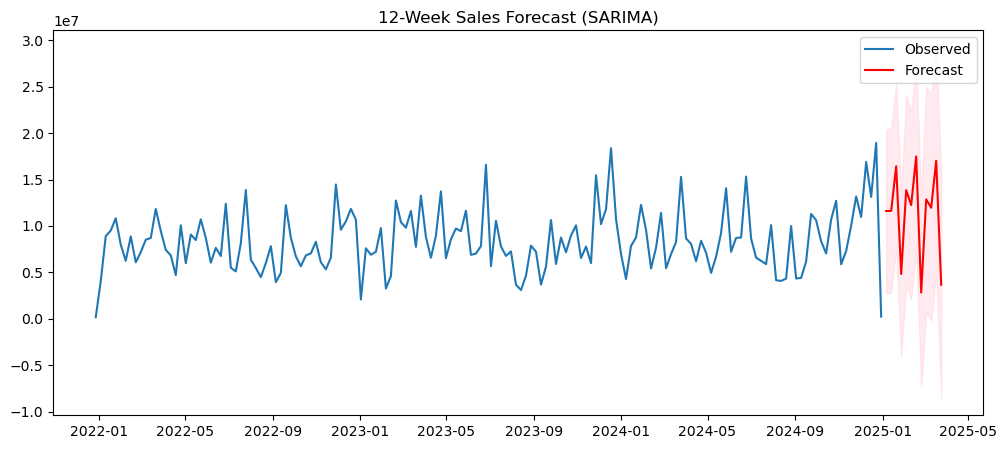

In [16]:
# Forecast next 12 weeks
forecast = results.get_forecast(steps=12)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(weekly_sales, label='Observed')
plt.plot(mean_forecast, label='Forecast', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("12-Week Sales Forecast (SARIMA)")
plt.legend()
plt.show()
